# Project 1. Анализ оттока клиентов банка.
Использована открытая база данных с сайта Kaggle.com (https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers)

Столбцы таблицы:
* RowNumber — номер строки таблицы (это лишняя информация, поэтому можете сразу от неё избавиться)
* CustomerId — идентификатор клиента
* Surname — фамилия клиента
* CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их)
* Geography — страна клиента (банк международный)
* Gender — пол клиента
* Age — возраст клиента
* Tenure — сколько лет клиент пользуется услугами банка
* Balance — баланс на счетах клиента в банке
* NumOfProducts — количество услуг банка, которые приобрёл клиент
* HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет)
* IsActiveMember — есть ли у клиента статус активного клиента банка (1 — да, 0 — нет)
* EstimatedSalary — предполагаемая заработная плата клиента
* Exited — статус лояльности (1 — ушедший клиент, 0 — лояльный клиент)

In [1]:
# import main librariees
import pandas as pd
import os

# Graphical libraries
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
plt.style.use('fast')


# ML libraries
from sklearn import linear_model, metrics, preprocessing
from sklearn.model_selection import train_test_split 

In [2]:
#Исследуем массив данных об оттоке клиентов некоторого банка. 
churn_data = pd.read_csv('data/churn.zip', sep=',') 

# Копируем таблицу, чтобы не испортить оригинальный массив данных
churn_df = churn_data.copy()

# RowNumber — номер строки таблицы (это лишняя информация, поэтому можем сразу от неё избавиться)
#churn_df.drop(['RowNumber'], axis=1, inplace=True) 

#Создадим графу 'client status' для наглядного отображения статуса пользования банком
churn_df['client status'] = churn_df['Exited'].astype('category').cat.rename_categories({0:'Клиент', 1:'Покинул банк'})

churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,client status
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Покинул банк
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Клиент
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Покинул банк
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Клиент
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Клиент


# Задание 9.1. 
----------
Каково соотношение ушедших и лояльных клиентов? Покажите это на графике и дайте комментарий по соотношению.

In [3]:
#данные
df=churn_df['client status'].value_counts().sort_values(ascending=False)

fig = px.pie(
    data_frame = df,
    values = 'client status',
    names = df.index,
    width=500, height=400,
    title='Рис.1 - Распределение клиентов по лояльности',
)

fig.update_layout(
    legend_title_text='Статус лояльности:'
)
#fig.update_traces(textposition='inside', textinfo='percent+label')
#fig.show();

# сохраним результат в папке figures. Если такой папки нет, то создадим её
if not os.path.exists("figures"):
    os.mkdir("figures")

fig.write_image('figures/fig_1.png', engine="kaleido")

<center> <img src = "figures/fig_1.png">

На рис.1 изображена круговая диаграмма распределения клиентов в зависимости от лояльности. В базе данных имеется: 10000 клиентов. Пользуются услугами банка 79,6 % или 7963 чел. Обозначенная оранжевым часть клиентов в 20,4 % или 2037 чел. покинула банк. 

# Задание 9.2. 
---------- 
Постройте график, показывающий распределение баланса пользователей, у которых на счету больше 2 500 долларов. Опишите распределение и сделайте выводы.


In [4]:
fig = px.box(
    data_frame = churn_df[churn_df['Balance'] > 2500],
    x = 'Balance',
    height=250, width=700, 
)

fig.update_layout(
    title=dict(text='Рис.2 - распределение балансов клиентских счетов, <br>превышающие 2500 долларов', x=.5, xanchor='center'),
    xaxis_title_text = 'Баланс клиентов, доллар', yaxis_title_text = 'Клиенты <br> банка'
)

#fig.show()
fig.write_image('figures/fig_2.png', engine="kaleido")

<center> <img src = "figures/fig_2.png">

На рис.2 изображено распределение балансов клиентских счетов, превосходящие 2500 долларов.
* В базе содержится 6383 клиента с таким остатоком на счету. Примерно половина из них (3250 клиента) имеют от 100 тыс. до 140 тыс. долларов на счету.
* Распределение баланса клиентского счета симметрично относительно среднего значения около 119827 долларов со стандартным отклонением около 30095 долларов. Медианный остаток составляет около 119840 долларов. 
* Половина клиентов имеет на счету средства, величина которых находится в относительно узком диапазоне. Межквартильный размах (IQR) составляет 39330 доллара. Границы распределения (диапазона) определим по формуле: нижняя граница Q25 - 1,5*IQR = 100182 - 1.5*39330 = 41187 долларов; верхняя граница Q75 + 1.5*IQR = 139512 + 1.5*39330 = 198507 долларов. 
* Минимальный остаток на счету составляет 3769 долларов, а максимальный 250898 долларов.
* Распределение данных близко к нормальному.

# Задание 9.3. 
---------- 
Посмотрите на распределение баланса клиента в разрезе признака оттока. Как различаются суммы на накопительном счёте ушедших и лояльных клиентов? Подумайте и напишите, с чем это может быть связано, что может не устраивать ушедших клиентов в банке.

In [5]:
#блочная диаграмма с помощью библиотеки Plotly

fig = px.box(
    data_frame = churn_df,
    x = 'Balance',
    y = 'client status',
    color = 'client status',
    height=300, width=800, 
)
fig.update_layout(
    title=dict(text='Рис.3 - распределение баланса счетов <br> в зависимости от статуса использования банка', x=.5, xanchor='center'),
    xaxis_title_text = 'Баланс клиента, доллар', yaxis_title_text = 'Статус <br>клиента', legend_title_text='Статус клиента:', 
)
#fig.show()
fig.write_image('figures/fig_3.png', engine="kaleido")

<center> <img src = "figures/fig_3.png">

На рис.3 изображена блочная диаграмма распределения остатков на счетах клиентов в разрезе признака оттока. Анализируя диаграммы, можно сказать, что у половины из 2037 покинувших банк клиентов на счету было от 37896 до 131435 долларов с медианным остатком около 109349 долларов. У половины оставшихся клиентов баланс составляет от 0 до 126419 долларов с медианным остатком около 92072 доллара. Такое различие между распределениями статка счёта позволяет сделать вывод о целях использования счетов клиентами: 
* большая часть ушедших клиентов хранила значительные суммы на счетах;
* текущие клиенты банка чаще используют счёт для текущих расходов и имеют меньший остаток, чем ушедшие клиенты.


# Задание 9.4. 
----------
Посмотрите на распределение возраста в разрезе признака оттока. В какой группе больше потенциальных выбросов? На какую возрастную категорию клиентов стоит обратить внимание банку?

In [6]:
#блочная диаграмма с помощью библиотеки Plotly
fig = px.box(
    data_frame = churn_df,
    x = 'Age',
    y = 'client status',
    color = 'client status',
    width=800, height=300,
)
fig.update_layout(
    title=dict(text='Рис. 4 - Распределение возраста ушедших клиентов <br>в разрезе признака оттока', x=.5, xanchor='center'),
    xaxis_title_text = 'Возраст клиента, лет', yaxis_title_text = 'Статус <br>клиента',  
    legend_title_text='Статус клиента:'
)
#fig.show()
fig.write_image('figures/fig_4.png', engine="kaleido")

<center> <img src = "figures/fig_4.png">

На рис.4 изображена блочная диаграмма распределения возратса клиентов в разрезе статуса использования банка. Анализируя диаграмму, можно сделать следующие выводы:
* больше всего выбросов данных в распределении возраста текущих клиентов банка. Медианный возраст клиентов составляет 36 лет. Однако, часто встречаются клиенты старше 57 лет;
* меньше всего выбросов в распределении покинувших банк клиентов. Их медианный возраст составляет 45 лет. Выбросы встречаются снаружи границ распределения - т.е. менее 18 лет либо более 72 лет. Половина ушедших клиентов была в возрасте от 38 до 51 года. Именно на эту групу клиентов следует обратить внимание менеджерам банка.

# Задание 9.5. 
----------
Постройте график, который показывает взаимосвязь кредитного рейтинга клиента и его предполагаемой зарплаты. Добавьте расцветку по признаку оттока клиентов. Какова взаимосвязь между признаками? Если не видите явной взаимосвязи, укажите это.

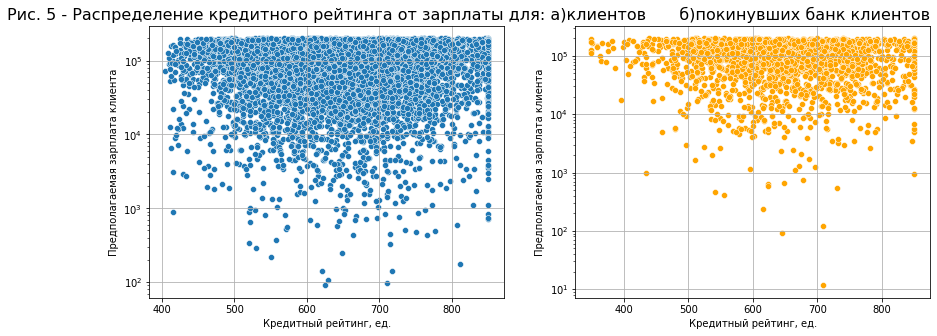

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# построим диаграммы рассеяния с помощью библиотеки Seaborn
sns.scatterplot(
    data=churn_df[churn_df['client status'] == 'Клиент'],
    x='CreditScore',
    y='EstimatedSalary', #marker="+",
    ax=axes[0]    
    ); 
# логарифмическая шкала по оси У
axes[0].set(yscale="log") #xscale="log"

axes[0].set_title('Рис. 5 - Распределение кредитного рейтинга от зарплаты для: а)клиентов', fontsize=16)
axes[0].set_xlabel('Кредитный рейтинг, ед.')
axes[0].set_ylabel('Предполагаемая зарплата клиента')
axes[0].grid();

#Диаграмма рассеяния 2 
sns.scatterplot(
    data=churn_df[churn_df['client status'] == 'Покинул банк'], #
    x='CreditScore',
    y='EstimatedSalary', 
    ax=axes[1],
    color='orange',
    ); 

# логарифмическая шкала по оси У
axes[1].set(yscale="log") #xscale="log"

axes[1].set_title('  б)покинувших банк клиентов', fontsize=16, loc='right')
axes[1].set_xlabel('Кредитный рейтинг, ед.')
axes[1].set_ylabel('Предполагаемая зарплата клиента')

axes[1].grid();

На рис.5 представлены диаграммы рассеяния кредитного рейтинга клиентов банка от предполагаемой зарплаты с учётом их статуса оттока: для текущих клиентов(слева) и для покинувших банк клиентов(справа). Поскольку на диаграмме без масштаба трудно определить взаимосвязь показателей, то воспользуемся логарифмической шкалой для визуализации параметра "предполагаемая зарплата клиента". Анализируя масштабные диаграммы можно сделать следующие выводы:
* распределение кредитного рейтинга практически не зависит от зарплаты клиента. Это означает, что большинство клиентов пользовались кредитной программой.
* предполагаемая средняя зарплата больнинства текущих и ушедших клиентов составляет около 100090 с отклонением в 57510 долларов.
* в верхней левой и верхней правой четвертях обеих дииаграмм можно выделить следующие группы клиентов:
1. "не пользующиеся кредитной программой банка" - покинувшие банк клиенты с низким кредитным рейтингом, но с высокой зарплатой;
2. "активные пользователи кредитной программы банка" - текущие клиенты с различной зарплатой и максимальным кредитным рейтингом.

# Задание 9.6. 
---------- 
Кто чаще уходит, мужчины или женщины? Постройте график, который иллюстрирует это.

In [8]:
# круговая диаграмма с помощью библиотеки Plotly
churn_df['Пол'] = churn_df['Gender'].apply(lambda x: 1 if x == 'Male' else '0')
df=churn_df[churn_df['client status'] == 'Покинул банк']['Gender'].value_counts()

fig = px.pie(
    data_frame = df,
    values = 'Gender',
    names = df.index,
    width=500, height=400,
)

fig.update_layout(
    title=dict(text='Рис.6 - Соотношение полов ушедших клиентов', x=.5, xanchor='center'),
    legend_title_text='Пол:'
)
#fig.show()
fig.write_image('figures/fig_6.png', engine="kaleido");

<center> <img src = "figures/fig_6.png">

На рис.6 представлена диаграмма распределения полов ушедших клиентов. Анализируя диаграмму, можно прийти к выводу, что женщины уходят чаще, чем мужчины.

# Задание 7 
----------
Как отток клиентов зависит от числа приобретённых у банка услуг? Для ответа на этот вопрос постройте многоуровневую столбчатую диаграмму.

In [9]:
# сгруппируем данные по количеству продуктов и статусу пользования банком
df = churn_df.groupby(['NumOfProducts', 'Exited'], as_index=False).count()

# построим столбчатую диаграмму с помощью библиотеки Plotly
fig = px.bar(
    data_frame=df,
    x='NumOfProducts',
    y='RowNumber',
    color='Exited',
    height=400,
    width=600,
    labels={'Exited':'Статус','RowNumber':'Количество клиентов','NumOfProducts':'Количество продуктов'},
    title='Рис. 7 - Использование услуг банка ушедшими клиентами',
    category_orders={'Exited': [1, 0]},
)

#fig.show()
fig.write_image('figures/fig_7.png', engine="kaleido")

<center> <img src = "figures/fig_7.png"> </center>

На рис.7 изображена диаграмма использования услуг банка ушедшими клиентами в зависимости от продолжительности использования услуг банка и наличия кредитной карты. Анализируя диаграмму, можно сделать следующие выводы:
* ушедшие клиенты пользовались банком около 5 лет;
* вариации у признаков "использование кредитной картой" и "количество приобретенных услуг" встречаются одинаково часто, что горвоит о том, что данные признаки не имели существенного влияния на желание покинуть банк.

# Задание 8 
----------
Как влияет наличие статуса активного клиента на отток клиентов? Постройте диаграмму, иллюстрирующую это. Что бы вы предложили банку, чтобы уменьшить отток клиентов среди неактивных?

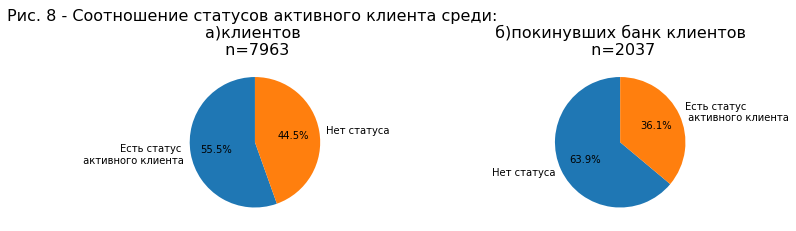

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3)) 
labels = 'Есть статус \n активного клиента', 'Нет статуса'
labels1 =  'Нет статуса', 'Есть статус \n активного клиента'

# круговая даиграмма 1 с помощью библиотеки matplotlib
ax1.pie(
    churn_df[churn_df['client status'] == 'Клиент']['IsActiveMember'].value_counts().sort_values(ascending=False),
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
)

ax1.set_title('Рис. 8 - Cоотношение статусов активного клиента среди: \nа)клиентов \n n=7963', fontsize=16)

# круговая даиграмма 2 с помощью библиотеки matplotlib
ax2.pie(
    churn_df[churn_df['client status'] == 'Покинул банк']['IsActiveMember'].value_counts().sort_values(ascending=False),
    labels=labels1,
    autopct='%1.1f%%',
    startangle=90,
)

ax2.set_title('  \n б)покинувших банк клиентов \n n=2037', loc='center', fontsize=16);

На рис.8 изображены диаграммы, показывающие клиентов с ушедшими клиетами по статусу активного клиента. Анализируя диаграммы, можно сделать следующий вывод:
* среди клиентов банка больше тех, которые имеют статус.
* среди покинувших банк клиентов больше "пассивных" - тех, которые не имели статуса. В связи с этим, можно порекоммендовать банку активнее выявлять потребности "пассивных" клиентoв и предлагать им соответствующие услуги.

# Задание 9
----------
В какой стране доля ушедших клиентов больше? Постройте тепловую картограмму, которая покажет это соотношение на карте мира. Предположите, с чем это может быть связано.

In [11]:
#данные
df = churn_data.groupby(['Geography'], as_index=False).mean()
#Количество 
#churn_df[churn_df['Exited']==1].groupby(['Exited','Geography'] , as_index=False).count() 

# построим картограмму с помощью библиотеки Plotly
fig = px.choropleth(
    df,
    locations="Geography",
    locationmode = "country names",
    color='Exited', #CustomerId
    title='Рис. 9 - Распределение ушедших клиентов по странам', 
    width=800,
    height=400,
    color_continuous_scale="Burg",
    labels={'Exited':'Покинувшие банк клиенты'}
)
fig.update_layout(title_font_size=16)
#fig.show()
fig.write_image('figures/fig_9.png', engine="kaleido")

<center> <img src = "figures/fig_9.png"> </center>

На рис.9 изображена диаграмма распределения ушедших клиентов по странам. Анализируя диаграмму отметим, что больше всего клиентов, 32.4%, покинуло немецкий филиал банка. Французский испанский филиалы банка покинуло примерно 16% кдиентов.
Принимая во внимание предыдущие диаграммы отметим, что кдиентам среднего возраста с высокой зарплатой из Германии и могло не понравитья особенности начисления кредитного рейтинга. Возможно, что из-за этого они начали активно пользоваться кредитной программой и не получили статус "активного клиента".

# Задание 10
----------
Переведите числовой признак CreditScore в категориальный. Для этого воспользуйтесь функцией get_credit_score_cat(), которая приведена ниже. Примените её к столбцу CreditScore и создайте новый признак CreditScoreCat — категории кредитного рейтинга.

Постройте сводную таблицу, строками которой являются категории кредитного рейтинга (CreditScoreCat), а столбцами — количество лет, в течение которых клиент пользуется услугами банка (Tenure). В ячейках сводной таблицы должно находиться среднее по признаку оттока (Exited) — доля ушедших пользователей.

На основе полученной сводной таблицы постройте тепловую карту с аннотацией. Найдите на тепловой карте категории клиентов, которые уходят чаще всего.

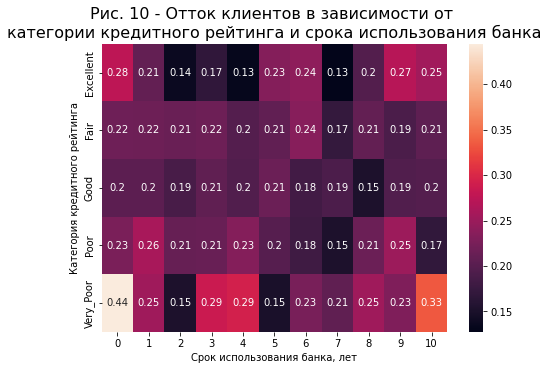

In [14]:
#функция распределения кредитного рейтинга на 5 групп по его значению
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"
    
# Отобразим результат в графе 'CreditScoreCat'
churn_df['CreditScoreCat'] = churn_df['CreditScore'].apply(get_credit_score_cat) 

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))

#данные
df = churn_df.pivot_table(values='Exited', index='CreditScoreCat', columns='Tenure', aggfunc='mean')

# строим тепловую диаграму с помощью библиотеки Seaborn. Параметр 'annot=True' показывает значения на диаграмме
sns.heatmap(df, annot=True ); #linewidths=.05

ax.set_title('Рис. 10 - Отток клиентов в зависимости от \nкатегории кредитного рейтинга и срока использования банка', fontsize=16)
ax.set_xlabel('Срок использования банка, лет')
ax.set_ylabel('Категория кредитного рейтинга');

plt.savefig(f'figures/fig_10.png')

На рис.10 изображена диаграмма оттока клиентов в зависимости от категории кредитного рейтинга и срока использования банка. Анализируя диаграмму, можно сделать следующие выводы:
* у клиеентов с очень низким кредитным рейтингом('very_poor') наблюдается максимальный отток (в порядке убывания интенсивности) втечение : 1, 4 и 5 года пользования банком. Возможно, уход клиентов обусловлен следующими мотивами: разочарование от низкой величиной кредитного рейтинга у вновь пришедших клиентов, которое ежегодно уменьшается в половину по мере использования кредитной программы. На 4 и 5 году это неприятие вновь увеличивается и разочарованные клиенты уходят. С 6-го года клиенты привыкают к условиям программы, но недовольство ею остаётся вплоть до 11-го года пользования банком.
* у клиентов с рейтингами 'poor', 'good', 'fair' не наблюдается значительных колебаний оттока
* у клиентов с рейтингом группы 'excellent' наблюдается схожая картина оттока по сравнению с группой 'very_poor', но интенсивность её меньше. Максимумы оттока наблюдаются на 1 и 10 и 11 годах. Также всплеск отток наблюдается в середине периода использования банка на 6 и 7 году - т.е. со смещением в 1 год позже  (по сравнению с группой 'very_poor'.

# Задача 11. Построение тепловой карты корреляции
---

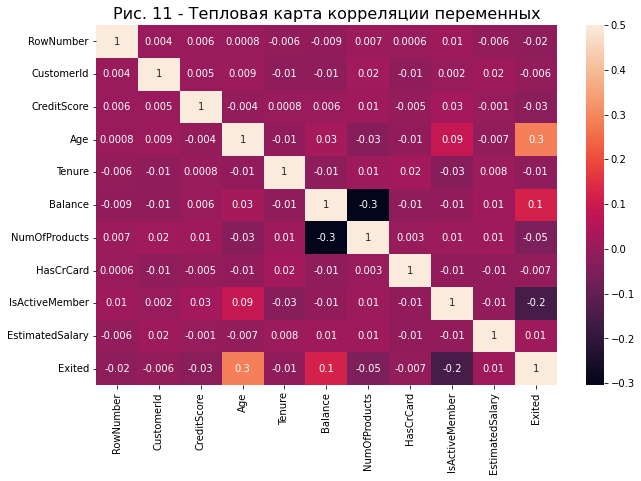

In [13]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes((0, 0, 1, 1))

fig = sns.heatmap(churn_df.corr(), annot=True, fmt='.1g', vmax=0.5) #, vmax=0.3
ax.set_title('Рис. 11 - Тепловая карта корреляции переменных', fontsize=16);

На рис. 11 изображена тепловая карта корреляции переменных между собой. Чем больше абсолютная величина коэффициента корреляции переменной в ячейке, тем сильнее взаимосвязь переменных соответственно. Анализируя диаграмму можно сделать следующие выводы:
* максимальная положительная связь усматривается между возрастом клиента и его статусом пользования банком;
* максимальная отрицательная связь между балансом и количеством услуг банка. Иными словами: чем больше баланс клиента- тем меньшим количеством услуг банка он пользуется.